In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax 
import jax.numpy as jnp
import haiku as hk
import optax

from functools import partial
import matplotlib.pyplot as plt

In [3]:
from models import core
from synthdata import chaosrnn

In [7]:
# use if reloading changed modules

# import importlib
# importlib.reload(chaosrnn)
# importlib.reload(core)

In [8]:
rng_key = jax.random.PRNGKey(32)

n_devices = jax.local_device_count()
# data is 4D tensor of n_timesteps x n_traj x spikes_per_traj x neurons
traj, rates, spikes = chaosrnn.gen_spikes(rng_key, 512, spikes_per_traj=10, base_rate=30, seconds=1, dt=0.01)

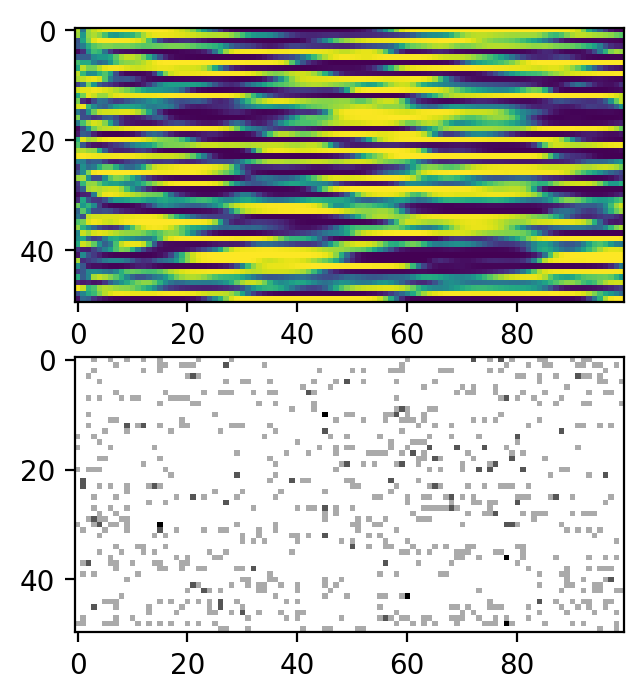

In [9]:
# check fig is similar to https://arxiv.org/pdf/1608.06315.pdf, albeit at lower sample resolution
# TODO: train models on dt=0.001 vs dt=0.01 used in prototyping
fig, ax = plt.subplots(nrows=2, dpi=200)
im1 = ax[0].imshow((rates[:, 11, 0, :]).T)
# darker = more spikes in bin
im2 = ax[1].imshow((-spikes[:, 11, 0, :]).T, cmap='gray')

In [10]:
# split data, 8 spike train per traj are train, remaining 2 are test
n_time, n_starts, n_traj, n_neurons = spikes.shape

train_spikes = spikes[:, :, :8, :].astype(jnp.float32).reshape(n_time, -1, n_neurons)

test_rates = rates[:, :, 8:, :].reshape(n_time, -1, n_neurons)
test_spikes = spikes[:, :, 8:, :].astype(jnp.float32).reshape(n_time, -1, n_neurons)

In [11]:
model = hk.transform(lambda x: core.LFADSAutonomous(hidden_dim=128, generator_dim=128, factors_dim=20, rates_dim=50)(x))

schedule_fn = optax.exponential_decay(-0.01, 1, 0.999)

optimizer = optax.chain(
    optax.clip_by_global_norm(10.0),
    optax.scale_by_adam(eps=1e-5),
    optax.scale_by_schedule(schedule_fn))

In [12]:
# let pmap work its magic
params = jax.pmap(lambda x: model.init(rng_key, x))(jnp.zeros(shape=(n_devices, n_time, 1, n_neurons)))
opt_state = jax.pmap(optimizer.init)(params)

In [13]:
@jax.jit
def loss_fn(params, rng_key, data, kl_weight=0):
    mean, stddev, factors, rates = model.apply(params, rng_key, data)

    nll = jax.scipy.stats.poisson.logpmf(data, rates).sum(axis=(0, -1)).mean()

    var = jnp.square(stddev)
    # TODO: KL loss should be w.r.t. var=0.1 NOT var=1
    kl_div = 0.5 * (-jnp.log(var) + jnp.square(mean) - 1.0 + var).sum(axis=(-1)).mean()

    # TODO: neater way of this L2 norm GRU state weights
    w_h = params["lfads_autonomous/rates_generator_autonomous/generator_gru"]["w_h"]
    l2_norm = jnp.square(w_h).sum() / w_h.size * 2000

    total = -nll + l2_norm + kl_div.mean() * kl_weight

    return total, {"nll": nll, "kl_div": kl_div, "l2_norm": l2_norm}

@partial(jax.pmap, axis_name='i')
def opt_fn(params, rng_key, opt_state, data, kl_weight=0):
    grads = jax.grad(lambda p, k, x, w: loss_fn(p, k, x, w)[0])(params, rng_key, data, kl_weight)
    grads = jax.lax.pmean(grads, axis_name="i")
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state

def kl_schedule(step):
    if step <= 4000: return 0 
    elif step < 6000: return (step - 4000)/2000
    else: return 1

In [14]:
BATCH_SIZE = 1024
keychain = hk.PRNGSequence(90)

for step in range(10000):
    kl_weight = jnp.repeat(kl_schedule(step), n_devices) 
    # TODO: add tfds dataloading for fast prefetches
    data = train_spikes[:, jax.random.randint(next(keychain), (BATCH_SIZE,), minval=0, maxval=train_spikes.shape[1]), :]
    data = jax.device_put_sharded(jnp.split(data, n_devices, axis=1), devices=jax.devices())
    params, opt_state = opt_fn(params, jax.random.split(next(keychain), n_devices), opt_state, data, kl_weight)
    
    if step % 500 == 0:
        mon_params = jax.tree_map(lambda x: x[0], params)
        print(step, kl_weight[0], loss_fn(mon_params, rng_key, data[0]))

0 0 (DeviceArray(4989.6606, dtype=float32), {'kl_div': DeviceArray(16.264786, dtype=float32), 'l2_norm': DeviceArray(14.896856, dtype=float32), 'nll': DeviceArray(-4974.7637, dtype=float32)})
500 0 (DeviceArray(1985.8481, dtype=float32), {'kl_div': DeviceArray(501.344, dtype=float32), 'l2_norm': DeviceArray(6.342616, dtype=float32), 'nll': DeviceArray(-1979.5055, dtype=float32)})
1000 0 (DeviceArray(1967.4729, dtype=float32), {'kl_div': DeviceArray(780.29065, dtype=float32), 'l2_norm': DeviceArray(5.658575, dtype=float32), 'nll': DeviceArray(-1961.8143, dtype=float32)})
1500 0 (DeviceArray(1948.1943, dtype=float32), {'kl_div': DeviceArray(1008.77057, dtype=float32), 'l2_norm': DeviceArray(5.190731, dtype=float32), 'nll': DeviceArray(-1943.0037, dtype=float32)})
2000 0 (DeviceArray(1943.7344, dtype=float32), {'kl_div': DeviceArray(1256.827, dtype=float32), 'l2_norm': DeviceArray(4.8663654, dtype=float32), 'nll': DeviceArray(-1938.868, dtype=float32)})
2500 0 (DeviceArray(1947.924, dtype

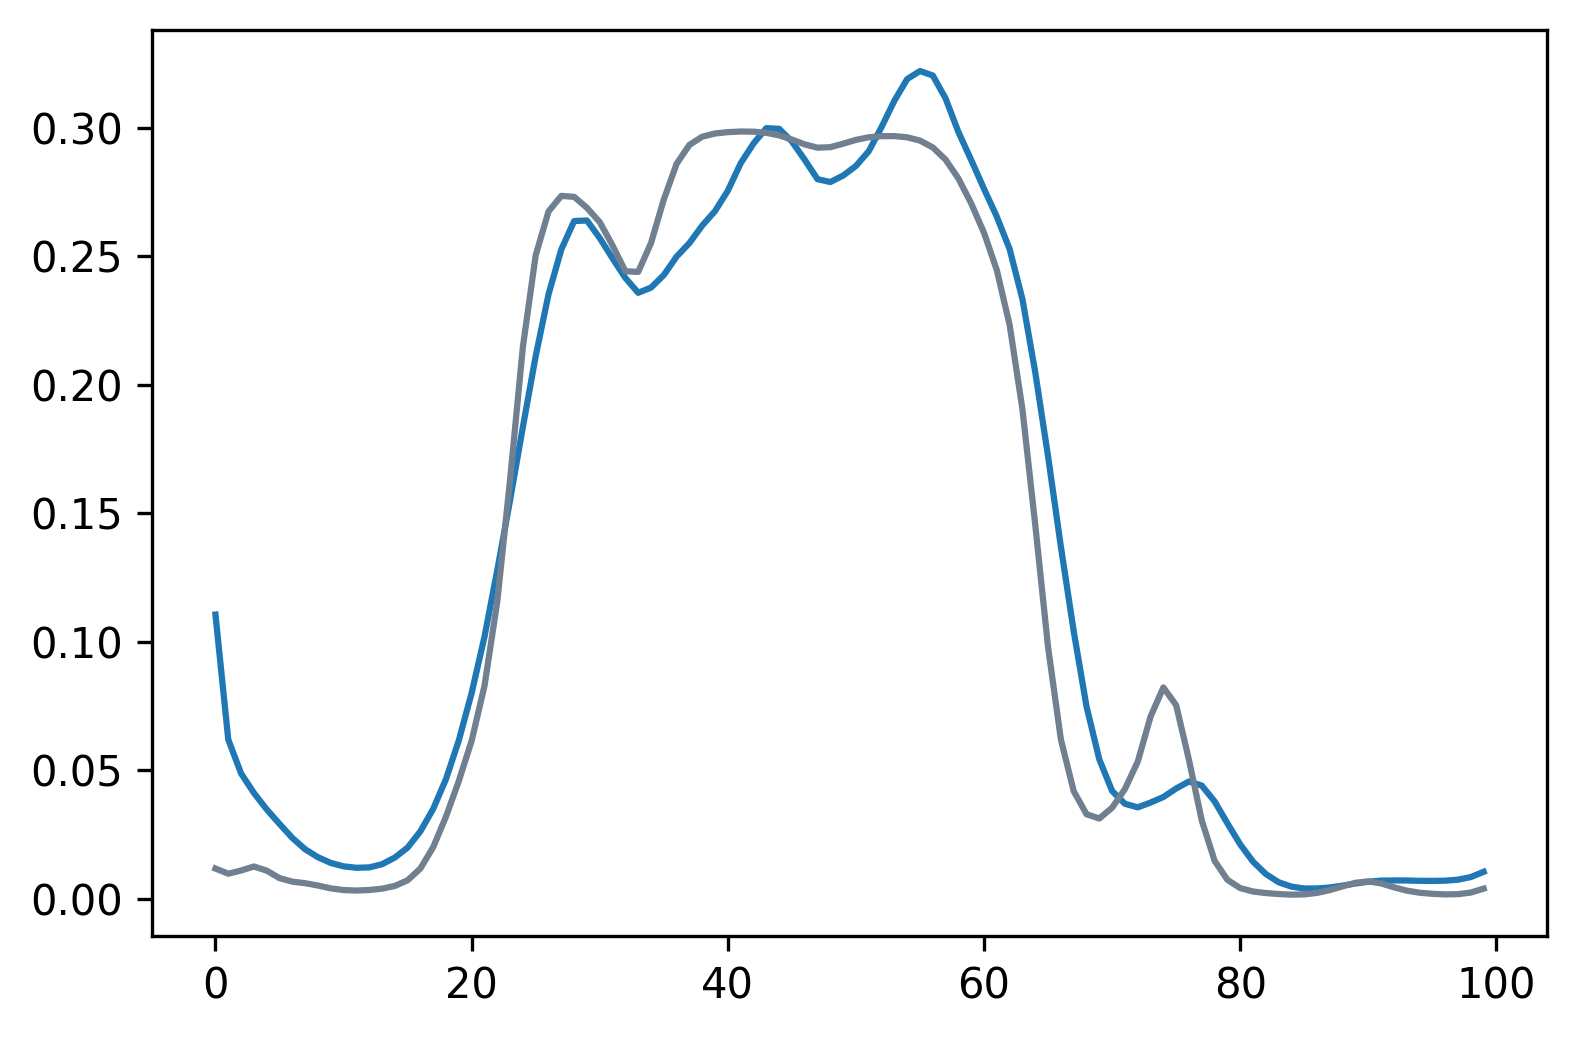

In [18]:
mono_params = jax.tree_map(lambda x: x[0], params)
model_test = hk.transform(lambda x: core.LFADSAutonomous(hidden_dim=128, generator_dim=128, factors_dim=20, rates_dim=50)(x, drop_rate=0.0))
m, v, _, pred_rates = model_test.apply(mono_params, rng_key, test_spikes)

fig, ax = plt.subplots(dpi=300)
im1 = ax.plot((pred_rates[:, 0, 5]).T)
im2 = ax.plot((test_rates[:, 0, 5]).T, color="slategray")
# im2 = ax.plot((test_spikes[:, 0, 5]).T, color="red")

0.84599


(array([  1.,   1.,   1.,   5.,  13.,  17.,  23.,  72., 153., 214.]),
 array([0.10270245, 0.19107235, 0.27944226, 0.36781217, 0.45618207,
        0.54455198, 0.63292189, 0.72129179, 0.8096617 , 0.89803161,
        0.98640151]),
 <BarContainer object of 10 artists>)

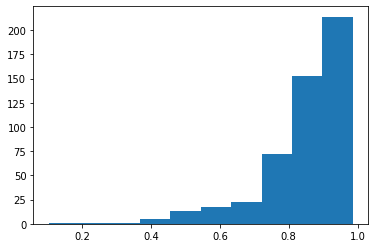

In [20]:
# sanity check only, NOT comprehensive
# get R^2 values for rates for 500 neurons
from scipy.stats import linregress
rs = [linregress(pred_rates[:, j, i], test_rates[:, j, i]) for i in range(50) for j in range(10)]
rsqs = [r**2 for (_, _, r, _, _, ) in rs]

print(jnp.mean(jnp.array(rsqs)))
plt.hist(rsqs)

In [ ]:
# gate biases (first 1/3rd of GRU b vec) seem to stay negative?
plt.plot(params["lfads_autonomous/rates_generator_autonomous/generator_gru"]["b"][0])